Текст завантажено! Довжина: 1003143 символів
Починаємо навчання... ☕
Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - loss: 3.0459
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - loss: 2.1473
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 1.8515
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 1.6754
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 1.5710
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 1.4957
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 1.4429
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 1.3909
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 1.3439
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 1.3087
Epoch 11/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 1.2684
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 1.2345
Epoch 13/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 1.1915
Epoch 14/20
155/155 ━━━━━━━━━━

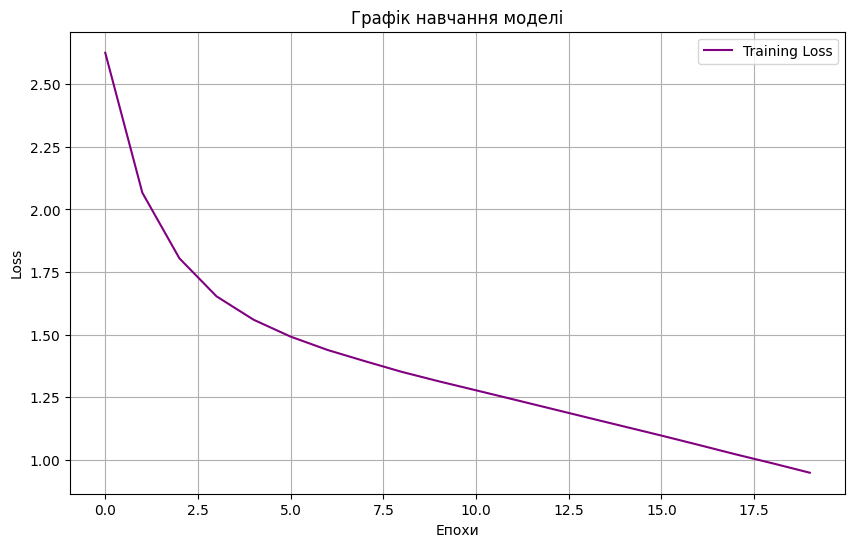


--- РЕЗУЛЬТАТ ---
Одного разу в Ширі. А тоді, коли він повинен страшна пониза, і гобіт бачив далі, початок наймовірніші за кожинки переповідали нову повернутися до вогню та за краще». — Він поїхав до Переправи в Північні дороги, перш ніж під час протилежного боку крутилися до низької землі та за ними, то тут Фродо приведуть вас доведеться сказати, що можна побачати вам добру мені доброго побачити в Ширі», але ти заганом її відпочити. Адже як же корабель, із якого виходило його на плечах.

— То все одно ми просимо, Семе, — відповів гобіт. — Це дуже добре податися сюди, тож нарешті вираз не завадивали зі собою. А вже не на сході, на якій легко було на дорозі в достовної землі. Вона закінчення де-не-де тремно згорилися, здавалося, почав голос од них. Попереду на ногах і на очі. Вони поволі зникла на верхівках і нападати на свій


In [4]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Embedding, InputLayer


# Завдання 1: Генерація тексту (RNN/LSTM)
# 1. ЗАВАНТАЖЕННЯ ТА ОБРОБКА ДАНИХ

path_to_file = 'sample_data/lotr.txt'
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Текст завантажено! Довжина: {len(text)} символів')

# Створюємо словник символів
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

# Нарізаємо на пакети
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
dataset = dataset.shuffle(10000).batch(64, drop_remainder=True)

# 2. СТВОРЕННЯ МОДЕЛІ (Keras 3 Compatible)
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

model = tf.keras.Sequential([
    # Використовуємо InputLayer для сумісності з Keras 3
    InputLayer(batch_shape=(64, None)),
    Embedding(vocab_size, embedding_dim),
    LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
    Dense(vocab_size)
])

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

# 3. НАВЧАННЯ
checkpoint_dir = './training_checkpoints'
# Розширення .weights.h5 для нових версій TensorFlow/Keras
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 20
print("Починаємо навчання... ☕")
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# 4. ГРАФІК LOSS
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.title('Графік навчання моделі')
plt.xlabel('Епохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

model_gen = tf.keras.Sequential([
    InputLayer(batch_shape=(1, None)),
    Embedding(vocab_size, embedding_dim),
    LSTM(rnn_units, return_sequences=True, stateful=True),
    Dense(vocab_size)
])

last_checkpoint = os.path.join(checkpoint_dir, f"ckpt_{EPOCHS}.weights.h5")
model_gen.load_weights(last_checkpoint)

def generate_text(model, start_string):
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []

    # Скидаємо шари вручну
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    # Генеруємо 800 символів
    for i in range(800):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        temperature = 0.6
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

print("\n--- РЕЗУЛЬТАТ ---")
# Починаємо генерацію
print(generate_text(model_gen, start_string=u"Одного разу в Ширі"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Завантаження даних...
Починаємо навчання на 80 епох...
Епоха 1, Gen Loss: 0.8467, Disc Loss: 1.0379, Час: 17.6 сек
Епоха 2, Gen Loss: 0.9251, Disc Loss: 1.2212, Час: 13.6 сек
Епоха 3, Gen Loss: 0.8848, Disc Loss: 1.2331, Час: 13.2 сек
Епоха 4, Gen Loss: 0.7973, Disc Loss: 1.3305, Час: 13.1 сек
Епоха 5, Gen Loss: 0.8755, Disc Loss: 1.2399, Час: 13.1 сек
Епоха 6, Gen Loss: 0.8171, Disc Loss: 1.3079, Час: 13.0 сек
Епоха 7, Gen Loss: 0.8739, Disc Loss: 1.2894, Час: 13.1 сек
Епоха 8, Gen Loss: 0.9301, Disc Loss: 1.2141, Час: 13.2 сек
Епоха 9, Gen Loss: 0.9656, Disc Loss: 1.1678, Час: 13.2 сек
Епоха 10, Gen Loss: 0.9307, Disc Loss: 1.2255, Час: 13.2 сек
Епоха 11, Gen Loss: 1.0161, Disc Loss: 1.1585, Час: 13.1 сек
Епоха 12, Gen Loss: 1.0301, Disc Loss: 1.1699, Час: 13.1 сек
Епоха 13, Gen Loss: 1.0327, Disc Loss: 1.1222, Час: 13.1 сек
Епоха 14, Gen Loss: 1.0810, Disc Loss: 1.0676, Час: 13.1 сек
Епоха 15, Gen Loss: 1.4094, Disc Loss: 0.9141, Час: 13.1 сек
Епоха 16, Gen Loss: 1.3813, Disc Loss: 

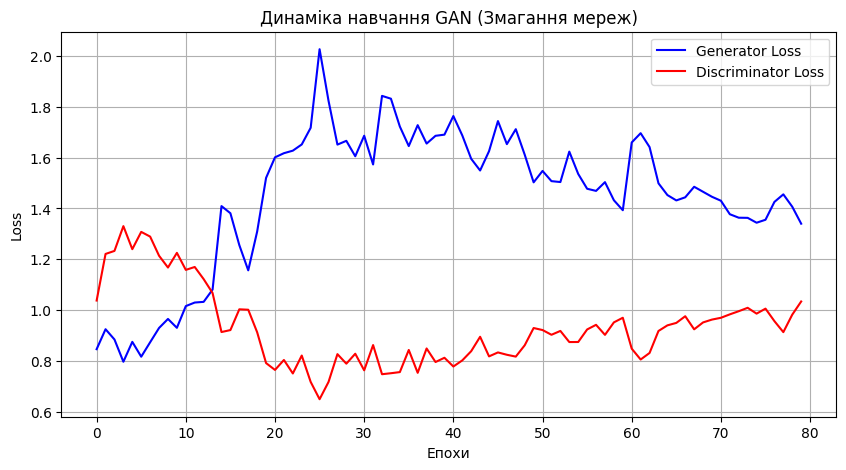

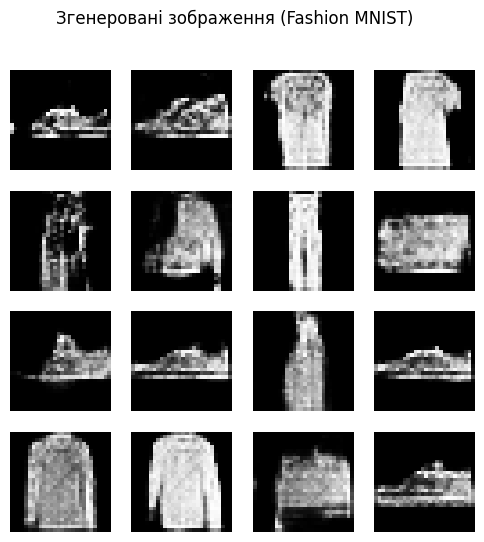

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time
# Завдання 2: Генерація зображень (DCGAN)


# 1. ЗАВАНТАЖЕННЯ ДАНИХ (Fashion MNIST)

print("Завантаження даних...")
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Нормалізація зображень до [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. СТВОРЕННЯ МОДЕЛЕЙ

def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        # Розгортаємо (Upsampling)
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# 3. НАЛАШТУВАННЯ ВТРАТ (LOSS)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# 4. ЦИКЛ НАВЧАННЯ

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Списки для зберігання історії
gen_losses_history = []
disc_losses_history = []

EPOCHS = 80
print(f"Починаємо навчання на {EPOCHS} епох...")

for epoch in range(EPOCHS):
    start = time.time()

    epoch_gen_loss = []
    epoch_disc_loss = []

    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)
        epoch_gen_loss.append(g_loss)
        epoch_disc_loss.append(d_loss)

    # Зберігаємо середній loss за епоху
    avg_g_loss = np.mean(epoch_gen_loss)
    avg_d_loss = np.mean(epoch_disc_loss)

    gen_losses_history.append(avg_g_loss)
    disc_losses_history.append(avg_d_loss)

    print(f'Епоха {epoch + 1}, Gen Loss: {avg_g_loss:.4f}, Disc Loss: {avg_d_loss:.4f}, Час: {time.time()-start:.1f} сек')


# 5. ГРАФІК LOSS

plt.figure(figsize=(10, 5))
plt.plot(gen_losses_history, label="Generator Loss", color="blue")
plt.plot(disc_losses_history, label="Discriminator Loss", color="red")
plt.title("Динаміка навчання GAN (Змагання мереж)")
plt.xlabel("Епохи")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# 6. ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТУ

noise = tf.random.normal([16, 100])
predictions = generator(noise, training=False)

plt.figure(figsize=(6, 6))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.suptitle("Згенеровані зображення (Fashion MNIST)")
plt.show()

In [7]:
from transformers import pipeline

# Завдання 3 b

# 1. ПЕРЕКЛАД (Translation)
# Використовуємо модель від Гельсінського університету (найпопулярніша для перекладу)
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-uk-en")

text_ukr = """Геть, Душе старий! Сяє сонце згори!
Як туман, розвійся, вий, лети з вітрами

У пустельний дикий край за найдальші гори!

Ніколи не вертай! Вилізай з кургану!

Зникни й забутий будь, мчи, від тьми темніший,

До навік замкнутих брам, аж до зміни світу."""

result_translation = translator(text_ukr)

print(f"\n🇺🇦 Оригінал: {text_ukr}")
print(f"🇬🇧 Переклад: {result_translation[0]['translation_text']}")
print("-" * 50)


# 2. ZERO-SHOT CLASSIFICATION (Класифікація без навчання)
# Ця модель (mDeBERTa) розуміє 100 мов, включаючи українську.
# Ми даємо їй текст і самі вигадуємо категорії на льоту.
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

text_news = "Верховна Рада ухвалила новий закон про оподаткування криптовалют."
candidate_labels = ["політика", "спорт", "економіка", "кулінарія"]

result_classification = classifier(text_news, candidate_labels, multi_label=False)

print(f"📰 Текст: {text_news}")
print("📊 Результат класифікації:")
for label, score in zip(result_classification['labels'], result_classification['scores']):
    print(f" - {label}: {score:.4f}")
print("-" * 50)


# 3. SUMMARIZATION (Анотація тексту)
# Модель mT5 від Google, донавчена на BBC News (включаючи українську службу)
summarizer = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum")

long_text = """
Чорна діра — це область простору-часу, гравітаційне тяжіння якої настільки велике, що покинути її не можуть навіть об'єкти, які рухаються зі швидкістю світла, зокрема кванти самого світла.
Межа цієї області називається горизонтом подій. Чорні діри є одними з найзагадковіших об'єктів у Всесвіті.
Теоретично можливість існування таких областей простору-часу випливає з деяких точних розв'язків рівнянь Ейнштейна, перше з яких було знайдене Карлом Шварцшильдом у 1915 році.
"""

summary = summarizer(long_text, max_length=30, min_length=10, do_sample=False)

print(f"📜 Довгий текст: {long_text[:100]}...")
print(f"✂️ Стислий зміст: {summary[0]['summary_text']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0



🇺🇦 Оригінал: Геть, Душе старий! Сяє сонце згори!
Як туман, розвійся, вий, лети з вітрами

У пустельний дикий край за найдальші гори!

Ніколи не вертай! Вилізай з кургану!

Зникни й забутий будь, мчи, від тьми темніший,

До навік замкнутих брам, аж до зміни світу.
🇬🇧 Переклад: The sun is shining from above! the mist, go away, go away, go away, fly with the winds into the desert wild country beyond the mountains, never return! Get out of the mound, and be forgotten, from the dark, to the darkest gates, to the change of the world.
--------------------------------------------------


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


📰 Текст: Верховна Рада ухвалила новий закон про оподаткування криптовалют.
📊 Результат класифікації:
 - політика: 0.7238
 - економіка: 0.2167
 - кулінарія: 0.0412
 - спорт: 0.0183
--------------------------------------------------


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0


📜 Довгий текст: 
Чорна діра — це область простору-часу, гравітаційне тяжіння якої настільки велике, що покинути її н...
✂️ Стислий зміст: У вівторок стало відомо про те, що Чорна діра — одна з найзагадковіших об'


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

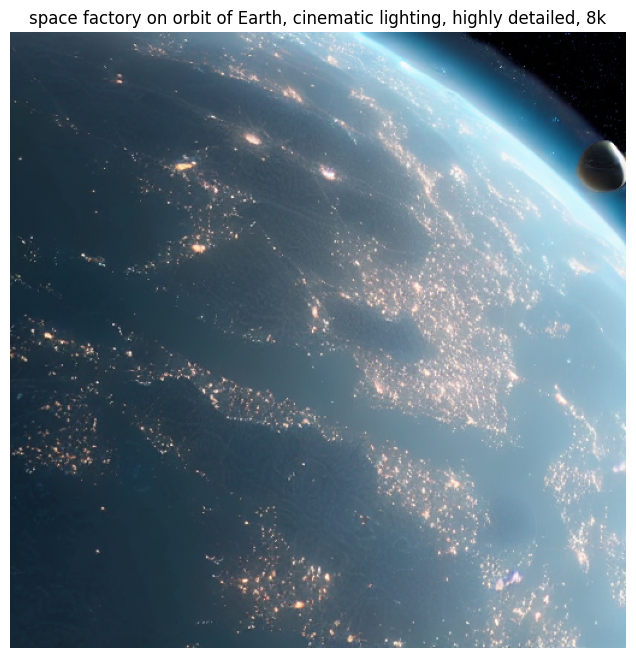

Зображення збережено як lab_result.png


In [8]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

# Завдання 3 c


# 1. Завантаження пайплайну
model_id = "runwayml/stable-diffusion-v1-5" # Найпопулярніша версія
#model_id = "CompVis/stable-diffusion-v1-4" # Трохи легша

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Переносимо на відеокарту
pipe = pipe.to("cuda")

# 2. Промпт (опис картинки)
prompt = "space factory on orbit of Earth, cinematic lighting, highly detailed, 8k"

# 3. Генерація

image = pipe(prompt).images[0]

# 4. Вивід
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(prompt)
plt.show()

image.save("lab_result.png")
print("Зображення збережено як lab_result.png")